<a href="https://colab.research.google.com/github/jimtoberfest/options_notebooks/blob/main/synthetic_variance_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#installs and imports

In [355]:
!pip install yfinance -q
!pip install opstrat -q

In [356]:
import yfinance as yf
import pandas as pd
import numpy as np
import opstrat as op


#Stock / Options Chain Download

In [357]:
upst = yf.Ticker("UPST")

In [358]:
upst_hist = upst.history(period="1d")
upst_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-12-31,153.229996,156.899994,151.070007,151.300003,2543200,0,0


##Set underlying Price Variable

In [359]:
#underlying Price

S = upst_hist.iloc[0]['Close']
S

151.3000030517578

#build OTM Options Chain

In [360]:
upst_expiries = upst.options

upst.opt = upst.option_chain(upst_expiries[3])

In [361]:
puts_otm = upst.opt.puts[upst.opt.puts['strike']<= S]
puts_otm['type'] = 'p'
calls_otm = upst.opt.calls[upst.opt.calls['strike']>= S]
calls_otm['type'] = 'c'

In [362]:
options_list = [puts_otm,calls_otm]
options_final = pd.concat(options_list)

In [363]:
options_final['mid'] = ((options_final['ask'] - options_final['bid']) / 2) + options_final['bid']


#Determine Strike Weights

In [571]:
# Weighting of the Strikes according to:   K_wt =(c / K^2)


options_final['weighted_K'] = 50000 / (options_final['strike']**2)

# options_final['weighted_K'] = 500 / (options_final['strike'])

# options_final['weighted_K'] = 1

options_final.tail()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K,calc_value,delta,gamma,theta,vega,dollar_gamma
29,UPST220128C00245000,2021-12-31 20:40:37+00:00,245.0,0.60,0.55,0.90,-0.20,-24.999998,8.0,3,0.965332,False,REGULAR,USD,c,0.725,0.832986,0.669739,0.044714,0.002351,-0.067702,0.039178,0.529050
30,UPST220128C00250000,2021-12-31 20:58:55+00:00,250.0,0.40,0.40,0.95,-0.35,-46.666668,20.0,56,0.984375,False,REGULAR,USD,c,0.675,0.800000,0.624722,0.041419,0.002168,-0.064893,0.036829,0.487710
31,UPST220128C00255000,2021-12-30 17:24:28+00:00,255.0,0.70,0.20,0.90,0.00,0.000000,3.0,6,0.979492,False,REGULAR,USD,c,0.550,0.768935,0.506524,0.034575,0.001880,-0.055718,0.031781,0.422968
32,UPST220128C00260000,2021-12-28 16:38:01+00:00,260.0,0.94,0.10,0.85,0.00,0.000000,1.0,24,0.984863,False,REGULAR,USD,c,0.475,0.739645,0.437570,0.030243,0.001674,-0.050162,0.028458,0.376671
33,UPST220128C00265000,2021-12-31 17:00:53+00:00,265.0,0.65,0.00,0.60,-0.20,-23.529417,13.0,6,0.945313,False,REGULAR,USD,c,0.300,0.711997,0.275234,0.020690,0.001269,-0.035024,0.020702,0.285475


In [572]:
# bsm=op.black_scholes(K=135, St=S, r=1.01, t=28, 
#                      v=81, type=type)
# bsm['value']['option value']
# bsm

In [573]:
# options_final['calc_value'] = options_final.apply(lambda x: bsm(x['strike'], S, 1.01, 28, x['impliedVolatility'],x['type']),axis=1)

#Calculate Greeks; Static Price, Vol, DTE

In [574]:
# S = upst_hist.iloc[0]['Close']

values = []
delta = []
gamma = []
theta = []
vega = []

for i in range(len(options_final)):
  K = options_final.iloc[i]['strike']
  St = S
  r = 1.01
  t = 28
  v = options_final.iloc[i]['impliedVolatility']
  type = options_final.iloc[i]['type']
  
  # print("inputs: ", K, St, r, t, v, type)

  n = op.black_scholes(K=K, St=S, r=r, t=t, 
                     v=v*100, type=type)

  val = n['value']['option value']
  de = n['greeks']['delta']
  ga = n['greeks']['gamma']
  th = n['greeks']['theta']
  ve = n['greeks']['vega']
  
  
  
  values.append(val)
  delta.append(de)
  gamma.append(ga)
  theta.append(th)
  vega.append(ve)


In [575]:
options_final['calc_value'] = values
options_final['delta'] = delta
options_final['gamma'] = gamma
options_final['theta'] = theta
options_final['vega'] = vega
options_final['dollar_gamma'] = (options_final['gamma']/100) * S**2

In [576]:
options_final.head(3)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K,calc_value,delta,gamma,theta,vega,dollar_gamma
0,UPST220128P00075000,2021-12-21 16:41:40+00:00,75.0,0.65,0.0,0.30,0.0,0.0,1.0,3,1.136723,False,REGULAR,USD,p,0.150,8.888889,0.159654,-0.009101,0.000520,-0.020657,0.010198,0.116943
1,UPST220128P00080000,2021-12-27 15:41:47+00:00,80.0,0.27,0.0,0.30,0.0,0.0,1.0,1,1.041020,False,REGULAR,USD,p,0.150,7.812500,0.160644,-0.009982,0.000615,-0.020506,0.011056,0.138439
2,UPST220128P00085000,2021-12-30 18:13:06+00:00,85.0,0.17,0.0,0.35,0.0,0.0,1.0,2,0.972657,False,REGULAR,USD,p,0.175,6.920415,0.189292,-0.012354,0.000793,-0.023057,0.013308,0.178350


#Select Strikes for Synth Var Swap (Manual)

In [577]:
v_ops = options_final.copy()

In [704]:
# K_select = [75,90,110,130,150,170,190,210,230]
# v_ops = options_final[options_final['strike'].isin(K_select)]


In [705]:
v_ops['wt_K'] = round(v_ops['weighted_K'])

# v_ops['wt_K'] = v_ops['weighted_K']

#Calc Position Greeks

In [706]:
v_ops['pos_delta'] = v_ops['delta'] * v_ops['wt_K'] * -1
v_ops['pos_gamma'] = v_ops['gamma'] * v_ops['wt_K'] * -1
v_ops['pos_theta'] = v_ops['theta'] * v_ops['wt_K'] * -1
v_ops['pos_vega'] = v_ops['vega'] * v_ops['wt_K'] * -1
v_ops['pos_dollar_gamma'] = v_ops['dollar_gamma'] * v_ops['wt_K']

v_ops['pos_premium'] = v_ops['calc_value'] * v_ops['wt_K']

In [707]:
v_ops.head(10)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K,calc_value,delta,gamma,theta,vega,dollar_gamma,wt_K,pos_delta,pos_gamma,pos_theta,pos_vega,pos_dollar_gamma,pos_premium
0,UPST220128P00075000,2021-12-21 16:41:40+00:00,75.0,0.65,0.00,0.30,0.00,0.000000,1.0,3,1.136723,False,REGULAR,USD,p,0.150,8.888889,0.159654,-0.009101,0.000520,-0.020657,0.010198,0.116943,9.0,0.081910,-0.004678,0.185916,-0.091778,1.052488,1.436883
3,UPST220128P00090000,2021-12-29 19:58:23+00:00,90.0,0.49,0.10,0.45,0.00,0.000000,1.0,20,0.949219,False,REGULAR,USD,p,0.275,6.172840,0.297296,-0.018882,0.001169,-0.032384,0.019156,0.263076,6.0,0.113293,-0.007015,0.194304,-0.114938,1.578455,1.783776
7,UPST220128P00110000,2021-12-31 18:08:51+00:00,110.0,0.90,0.85,1.20,-0.07,-7.216500,8.0,72,0.812990,False,REGULAR,USD,p,1.025,4.132231,1.100786,-0.067662,0.003872,-0.078578,0.054340,0.871310,4.0,0.270649,-0.015490,0.314314,-0.217362,3.485240,4.403145
11,UPST220128P00130000,2021-12-31 20:11:34+00:00,130.0,4.38,4.10,5.30,0.18,4.285722,14.0,74,0.813112,False,REGULAR,USD,p,4.700,2.958580,4.958006,-0.226187,0.008905,-0.180381,0.124972,2.003533,3.0,0.678562,-0.026714,0.541144,-0.374915,6.010598,14.874017
15,UPST220128P00150000,2021-12-31 20:11:34+00:00,150.0,12.01,12.20,13.40,-0.99,-7.615383,10.0,80,0.809084,False,REGULAR,USD,p,12.800,2.222222,13.318765,-0.454023,0.011790,-0.235618,0.164641,2.652639,2.0,0.908046,-0.023579,0.471237,-0.329281,5.305278,26.637529
14,UPST220128C00170000,2021-12-31 20:58:43+00:00,170.0,7.10,6.30,7.70,-4.69,-39.779476,12.0,74,0.817751,False,REGULAR,USD,c,7.000,1.730104,6.595439,0.331437,0.010678,-0.221282,0.150718,2.402585,2.0,-0.662874,-0.021356,0.442564,-0.301436,4.805170,13.190877
18,UPST220128C00190000,2021-12-31 19:20:39+00:00,190.0,4.00,2.85,4.00,-1.30,-24.528305,2.0,38,0.841676,False,REGULAR,USD,c,3.425,1.385042,3.197494,0.185623,0.007650,-0.167708,0.111129,1.721140,1.0,-0.185623,-0.007650,0.167708,-0.111129,1.721140,3.197494
22,UPST220128C00210000,2021-12-31 16:27:37+00:00,210.0,2.15,1.15,2.30,-0.18,-7.725315,1.0,17,0.872072,False,REGULAR,USD,c,1.725,1.133787,1.598563,0.102209,0.004922,-0.115746,0.074082,1.107375,1.0,-0.102209,-0.004922,0.115746,-0.074082,1.107375,1.598563
26,UPST220128C00230000,2021-12-30 18:31:05+00:00,230.0,1.65,0.45,1.20,0.00,0.000000,6.0,37,0.887208,False,REGULAR,USD,c,0.825,0.945180,0.758932,0.053321,0.002945,-0.071646,0.045096,0.662595,1.0,-0.053321,-0.002945,0.071646,-0.045096,0.662595,0.758932


In [708]:
print("  delta: ",v_ops['pos_delta'].sum()*100,'\n',
' gamma: ',v_ops['pos_gamma'].sum()*100,'\n',
' theta: ',v_ops['pos_theta'].sum()*100,'\n',
'  vega: ', v_ops['pos_vega'].sum()*100, '\n',
'$gamma:', v_ops['pos_dollar_gamma'].sum())


  delta:  104.84337698623388 
  gamma:  -11.434816447146131 
  theta:  250.4578354483382 
   vega:  -166.0016582678208 
 $gamma: 25.7283370060788


In [709]:
v_ops['pos_premium'].sum()*100

6788.121701211311

#Graph Terminal Payout Risk (manual)

In [710]:
9,6,4,3,2,2,1,1,1   #how many of each strike

(9, 6, 4, 3, 2, 2, 1, 1, 1)

In [711]:
op1={'op_type': 'p', 'strike': 90, 'tr_type': 's', 'op_pr': .30}
op2={'op_type': 'p', 'strike': 110, 'tr_type': 's', 'op_pr': 1.00}
op3={'op_type': 'p', 'strike': 130, 'tr_type': 's', 'op_pr': 4.65}
op4={'op_type': 'p', 'strike': 150, 'tr_type': 's', 'op_pr': 12.75}
op5={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 7.00}
op6={'op_type': 'c', 'strike': 190, 'tr_type': 's', 'op_pr': 3.45}
op7={'op_type': 'c', 'strike': 210, 'tr_type': 's', 'op_pr': 1.70}
op8={'op_type': 'c', 'strike': 230, 'tr_type': 's', 'op_pr': .85}
op11={'op_type': 'p', 'strike': 75, 'tr_type': 's', 'op_pr': .15}

# Using a live fence as a heage as the op.multiplotter cant do a true delta hedge
op9={'op_type': 'p', 'strike': 150, 'tr_type': 'b', 'op_pr': 12.75}  #hedge
op10={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 7.00}  #hedge


op_list=[op11,op11,op11,op11,op11,op11,op11,op11,op11,op1,op1,op1,op1,op1,op1,op2,op2,op2,op2, op3,op3,op3, op4,op4, op5,op5, op6, op7, op8]

hedged_op_list=[op11,op11,op11,op11,op11,op11,op11,op11,op11,op1,op1,op1,op1,op1,op1,op2,op2,op2,op2, op3,op3,op3, op4,op4, op5,op5, op6, op7, op8, op9, op10, op6]



##Graphs

In [712]:
# op.multi_plotter(spot=S,spot_range=(40), op_list=op_list)

In [713]:
# op.multi_plotter(spot=S,spot_range=(40), op_list=hedged_op_list)

#Create Better Graphs with Greek Risks over Price and Time

In [714]:
# To Do, see above title
'''
Loop 1. set price, IGNORE outer price loop for now...!!!!!
Loop 2. set day, add .0001 to each time step to get expiry calc w/o having a zero
          calc options
          multiply by position
          sum pos risks
          record in df: dte, value, delta, gamma, theta, vega

'''

'\nLoop 1. set price, IGNORE outer price loop for now...!!!!!\nLoop 2. set day, add .0001 to each time step to get expiry calc w/o having a zero\n          calc options\n          multiply by position\n          sum pos risks\n          record in df: dte, value, delta, gamma, theta, vega\n\n'

In [715]:
# from numpy.lib.shape_base import vsplit
# Create DF to hold output
columns = ['dte', 'value', 'delta', 'gamma', 'theta', 'vega']
holding = pd.DataFrame(columns=columns)


# Days Loop
for days in range(1, 29):
  days = days


  values = []
  delta = []
  gamma = []
  theta = []
  vega = []


  #Strikes Loop
  for i in range(len(v_ops)):
    K = v_ops.iloc[i]['strike']
    St = S
    r = 1.01
    t = days
    v = v_ops.iloc[i]['impliedVolatility']
    # v = .80
    type = v_ops.iloc[i]['type']
    
    # print("inputs: ", K, St, r, t, v, type)

    n = op.black_scholes(K=K, St=S, r=r, t=t, 
                      v=v*100, type=type)

    
    # How many of each option o we need for the position
    pos_multi = v_ops.iloc[i]['wt_K']

    val = n['value']['option value'] * pos_multi
    de = n['greeks']['delta'] * pos_multi
    ga = n['greeks']['gamma'] * pos_multi
    th = n['greeks']['theta'] * pos_multi
    ve = n['greeks']['vega'] * pos_multi
    
    values.append(val)
    delta.append(de)
    gamma.append(ga)
    theta.append(th)
    vega.append(ve)

  vs = sum(values) * 100
  ds = sum(delta) * 100 * -1
  gs = sum(gamma) * 100 * -1
  ts = sum(theta) * 100 * -1
  vegs = sum(vega) * 100 * -1

  t_list = [days,vs,ds,gs,ts,vegs]
  # print(t_list)
  holding = holding.append(pd.Series(t_list, index=holding.columns), ignore_index=True)


In [716]:

holding['dollar_gamma'] = (holding['gamma']/100) * S**2

holding

,dte,value,delta,gamma,theta,vega,dollar_gamma
0,1.0,507.249862,97.994916,-12.802732,257.986521,-6.386504,-2880.614663
1,2.0,736.864849,95.761656,-10.714695,216.400603,-10.703487,-2410.806331
2,3.0,951.963529,94.152130,-10.646814,215.561090,-15.973177,-2395.533174
3,4.0,1169.045995,93.190788,-10.776037,218.588952,-21.576076,-2424.608295
4,5.0,1388.864266,92.543207,-10.872147,220.881944,-27.231548,-2446.233085
5,6.0,1610.528763,92.052597,-10.928233,222.338787,-32.869620,-2458.852450
6,7.0,1833.386432,91.665907,-10.960917,223.325267,-38.489810,-2466.206320
7,8.0,2057.116686,91.370072,-10.982703,224.120117,-44.109335,-2471.108112
8,9.0,2281.619445,91.166016,-11.000793,224.890829,-49.747260,-2475.178361
9,10.0,2506.921402,91.058926,-11.018927,225.729176,-55.420039,-2479.258508


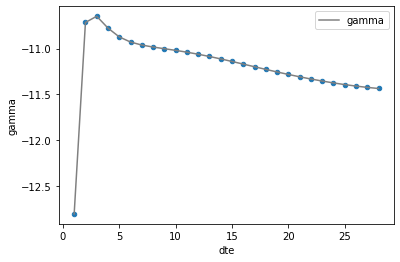

In [717]:
ax = holding.plot.scatter(x='dte', y='gamma')
holding.plot.line(x='dte', y='gamma', ax=ax, color='grey')

In [730]:
columns = ['price', 'value', 'delta', 'gamma', 'theta', 'vega']
price_holding = pd.DataFrame(columns=columns)

S = 150
# Price Loop
base = holding.iloc[27]['value']

for price in range(100,200):
  
  values = []
  delta = []
  gamma = []
  theta = []
  vega = []


  #Strikes Loop
  for i in range(len(v_ops)):
    K = v_ops.iloc[i]['strike']
    St = price
    r = 1.01
    t = 15
    v = v_ops.iloc[i]['impliedVolatility']
    v = .80
    
    
    type = v_ops.iloc[i]['type']
    
    # print("inputs: ", price,K, St, r, t, v, type)

    n = op.black_scholes(K=K, St=St, r=r, t=t, 
                      v=v*100, type=type)

    
    # How many of each option o we need for the position
    pos_multi = v_ops.iloc[i]['wt_K']

    val = n['value']['option value'] * pos_multi
    de = n['greeks']['delta'] * pos_multi
    ga = n['greeks']['gamma'] * pos_multi
    th = n['greeks']['theta'] * pos_multi
    ve = n['greeks']['vega'] * pos_multi
    
    values.append(val)
    delta.append(de)
    gamma.append(ga)
    theta.append(th)
    vega.append(ve)

  vs = sum(values) * 100 
  ds = sum(delta) * 100 * -1
  gs = sum(gamma) * 100 * -1
  ts = sum(theta) * 100 * -1
  vegs = sum(vega) * 100 * -1

  t_list = [price,vs,ds,gs,ts,vegs]
  # print(t_list)
  price_holding = price_holding.append(pd.Series(t_list, index=price_holding.columns), ignore_index=True)


In [731]:
price_holding['dollar_gamma'] = (price_holding['gamma']/100) * price_holding['price']**2 * -1
price_holding['pnl'] = price_holding['value']*-1 + holding.iloc[27]['value']
price_holding

,price,value,delta,gamma,theta,vega,dollar_gamma,pnl
0,100.0,27209.135442,986.929833,-27.459840,331.372758,-105.556383,2745.983954,-20421.013741
1,101.0,26235.859083,959.699383,-27.000868,328.808259,-105.299894,2754.358593,-19447.737382
2,102.0,25289.583534,932.928331,-26.541189,326.123210,-104.996988,2761.345310,-18501.461833
3,103.0,24369.849185,906.616961,-26.081638,323.336086,-104.651748,2767.000983,-17581.727484
4,104.0,23476.196549,880.764756,-25.622981,320.464211,-104.268058,2771.381624,-16688.074848
...,...,...,...,...,...,...,...,...
95,195.0,8599.218656,-269.988778,-5.458678,203.542662,-71.913667,2075.662448,-1811.096955
96,196.0,8871.920577,-275.398909,-5.361759,202.349097,-71.421006,2059.773414,-2083.798875
97,197.0,9149.984344,-280.712647,-5.265890,201.125287,-70.918770,2043.639175,-2361.862643
98,198.0,9433.314088,-285.931038,-5.171066,199.871404,-70.407081,2027.264820,-2645.192387


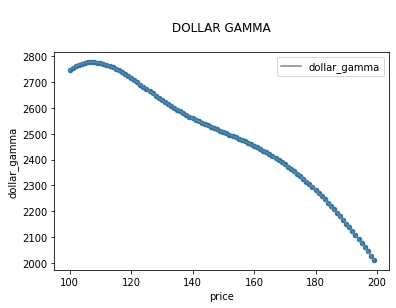

In [732]:
ax = price_holding.plot.scatter(x='price', y='dollar_gamma')
price_holding.plot.line(x='price', y='dollar_gamma', ax=ax, color='grey', title='\nDOLLAR GAMMA\n')

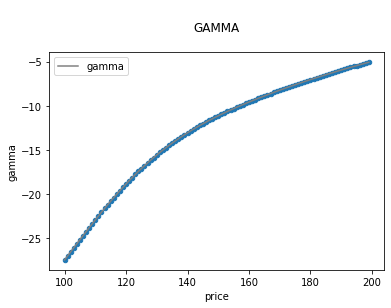

In [733]:
ax = price_holding.plot.scatter(x='price', y='gamma')
price_holding.plot.line(x='price', y='gamma', ax=ax, color='grey', title='\nGAMMA\n')

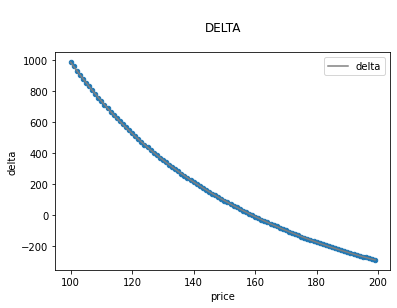

In [734]:
ax = price_holding.plot.scatter(x='price', y='delta')
price_holding.plot.line(x='price', y='delta', ax=ax, color='grey', title='\nDELTA\n')

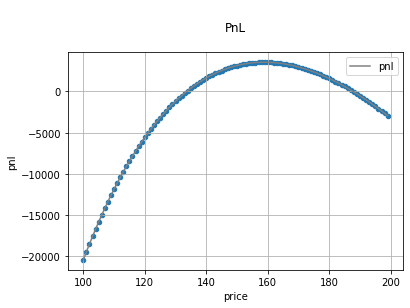

In [735]:
ax = price_holding.plot.scatter(x='price', y='pnl')

price_holding.plot.line(x='price', y='pnl', ax=ax, color='grey', title='\nPnL\n', grid=True)
